In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWid            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours
th < upper_width and intHeight > lower_height and intHeight < upper_height :

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [29]:
# Find characters in the resulting images

def segment_characters(image) :
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

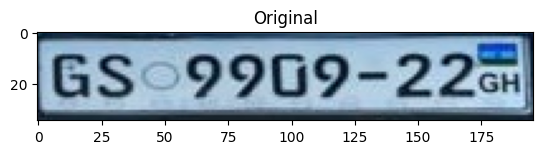

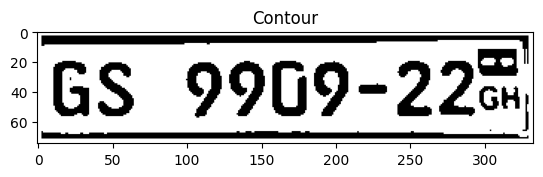

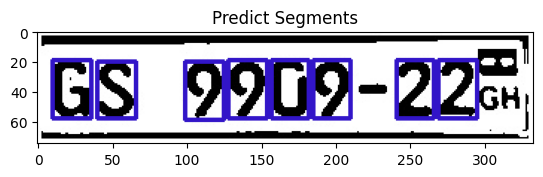

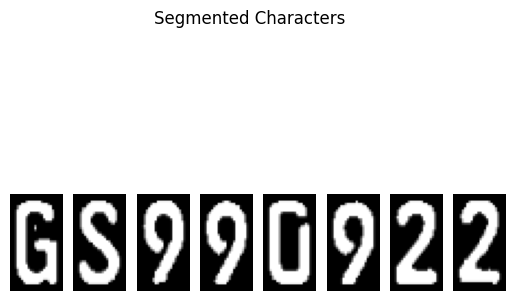

In [30]:
image_path = 'plate_crops/img_000052_0.jpg'#52,59,5,27
image = cv2.imread(image_path)
plt.imshow(image)
plt.title('Original')
plt.show()
char_images = segment_characters(image)

# Show all segmented characters
for i, char_img in enumerate(char_images):
    plt.subplot(1, len(char_images), i + 1)
    plt.imshow(char_img, cmap='gray')
    plt.axis('off')
plt.suptitle("Segmented Characters")
plt.show()

In [31]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data/data'
train_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(28,28),
    batch_size=1,
    class_mode='sparse'
)

validation_generator = train_datagen.flow_from_directory(
    path + '/val',
    target_size=(28,28),
    batch_size=1,
    class_mode='sparse'
)


c:\Users\FIADOR KELVIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
# Train the model (uncomment and adjust epochs as needed)
model.fit(train_generator, epochs=20, validation_data=validation_generator)


Epoch 1/20


c:\Users\FIADOR KELVIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


864/864 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.0790 - loss: 3.4330 - val_accuracy: 0.4074 - val_loss: 1.9524
Epoch 2/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.5580 - loss: 1.4537 - val_accuracy: 0.7037 - val_loss: 0.9667
Epoch 3/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.7447 - loss: 0.8004 - val_accuracy: 0.8981 - val_loss: 0.2978
Epoch 4/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.8858 - loss: 0.3618 - val_accuracy: 0.8750 - val_loss: 0.3990
Epoch 5/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.8585 - loss: 0.4587 - val_accuracy: 0.9120 - val_loss: 0.2874
Epoch 6/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.8934 - loss: 0.3289 - val_accuracy: 0.9306 - val_loss: 0.2383
Epoch 7/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9374 - loss: 0.2147 - val_accuracy: 0.9722 - val_loss: 0.1399
Epoch 8/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9342 - loss: 0.2733 - val_accurac

ValueError: The filename must end in `.weights.h5`. Received: filepath=final_weights.h5

In [33]:
# Save just the weights:
model.save_weights('final_weights.weights.h5')

# Or save the entire model (architecture + weights + optimizer state):
model.save('final_model.keras')


In [ ]:
model = load_model('final_model.keras')

In [34]:
# Function to convert grayscale to 3-channel image
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

# Function to predict and display results
def show_results(char_list):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_list:
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = np.argmax(model.predict(img), axis=-1)[0]
        character = dic[y_]
        output.append(character)
    plate_number = ''.join(output)
    return plate_number

In [35]:
# Example usage (uncomment and provide your own char_list)
char_list = [char_images[i] for i in range(len(char_images))]
plate_number = show_results(char_list)
print(plate_number)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
GS99D922
